# Pill 15 - SVM for imbalanced datasets

Author: **Alberto Huélamo-Segura**

In this notebook I take the code from the class notebook's soft magin SVM and I adapt its implementation to deal with imbalanced datasets.

We need to find a suitable boundary for the following dataset.

(320, 2) (320,)


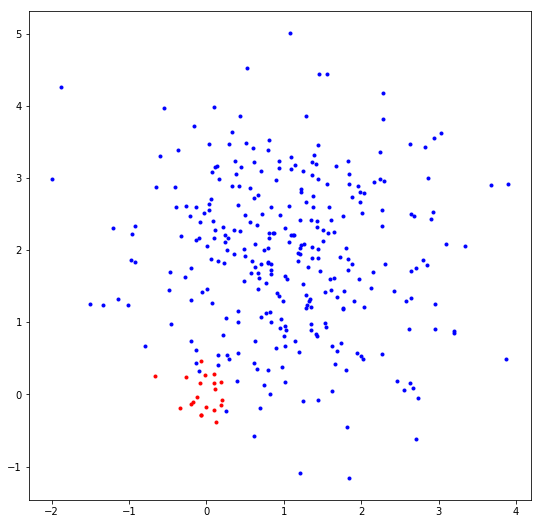

In [44]:
%matplotlib inline
import numpy as np
Nneg = 20
Npos = 300

m1 = [0.,0.]
s1 = [[0.05,0],[0,0.05]]
m2 = [1.,2.]
s2 = [[1,0],[0,1]]
c1 = np.random.multivariate_normal(m1,s1,Nneg)
c2 = np.random.multivariate_normal(m2,s2,Npos)


x= np.r_[c1,c2]
yneg = -np.ones(c1.shape[0])
ypos = np.ones(c2.shape[0])
y= np.r_[yneg, ypos]


print (x.shape,y.shape)
import matplotlib.pyplot as plt


plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')


plt.gcf().set_size_inches((9,9))

## Normal formulation

The problem is that a normal SVM formulation will find a boundary in which the minority class can be almost entirely inside the margin.

In [45]:
from cvxpy import *
import numpy

d = x.shape[1] 
N = x.shape[0]
C = 100.

# Construct the problem.
# Declare variables
a = Variable(d)
b = Variable()
xi = Variable(N)
objective = Minimize(norm(a) + C*sum(xi))
constraints = [multiply(y, x*a+b)>=1-xi, xi>=0]

prob = Problem(objective,constraints)
prob.solve()
prob.status

'optimal'

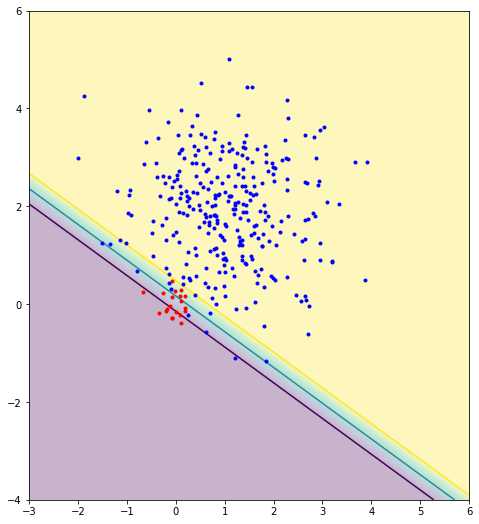

In [46]:
xx,yy = np.meshgrid(np.linspace(-3,6,200),np.linspace(-4,6,200))
viz=np.c_[xx.ravel(),yy.ravel()]


z = np.dot(viz,a.value)+b.value

plt.plot(c1[:,0],c1[:,1],'r.')
plt.plot(c2[:,0],c2[:,1],'b.')
plt.gca().set_xlim([-3.,6.])
plt.gca().set_ylim([-4.,6.])
plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,6,-4,6),alpha=0.3, vmin=-1, vmax=1)
plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])

plt.gcf().set_size_inches((9,9))

## Class-Weighted SVM

We can reformulate SVM to deal with imbalance datasets by adding misclassification penalties for both of the classes.

$$
\begin{align}
\min_{\mathbf{w},b,\xi} &\quad \sum_{i=1}^N\sum_{j=1}^N \alpha_i \alpha_j y_i y_j \kappa(\mathbf{x}_i,\mathbf{x}_j)  + C_{pos}\sum_{i\in \mathcal{P}} \xi_i + C_{neg}\sum_{i\in \mathcal{N}}\xi_i, \\
s.t. &\quad y_i\big(\sum_{j=1}^N \alpha_j y_j \kappa(\mathbf{x}_i, \mathbf{x}_j) + b\big) \geq 1-\xi_i,& i=1\ldots N \\
&\quad \xi_i \geq 0, & i=1\ldots N
\end{align}$$

In [56]:
from cvxpy import *
import numpy

def foo(Cneg=1, Cpos=0.01):
    d = x.shape[1]
    #Cneg = 1#1/Nneg
    #Cpos = 0.01#1/Npos
    print(f'Cneg={Cneg}\nCpos={Cpos}')

    # Construct the problem.
    # Declare variables
    a = Variable(d)
    b = Variable()
    xi = Variable(Nneg)
    xj = Variable(Npos)
    objective = Minimize(norm(a) + Cneg*sum(xi) + Cpos*sum(xj))
    constraints = [multiply(yneg, c1*a+b)>=1-xi, multiply(ypos, c2*a+b)>=1-xj, xi>=0, xj>=0]

    prob = Problem(objective, constraints)
    prob.solve()
    print(prob.status)

    xx,yy = np.meshgrid(np.linspace(-3,6,200),np.linspace(-4,6,200))
    viz=np.c_[xx.ravel(),yy.ravel()]


    z = np.dot(viz,a.value)+b.value

    plt.plot(c1[:,0],c1[:,1],'r.')
    plt.plot(c2[:,0],c2[:,1],'b.')
    plt.gca().set_xlim([-3.,6.])
    plt.gca().set_ylim([-4.,6.])
    plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-3,6,-4,6),alpha=0.3, vmin=-1, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)),[-1.,0.,1.])

    plt.gcf().set_size_inches((9,9))

With this formulation, increasing the penalty for the red class, we can allow how many points fall inside the margin.

Cneg=1.0
Cpos=0.1
optimal


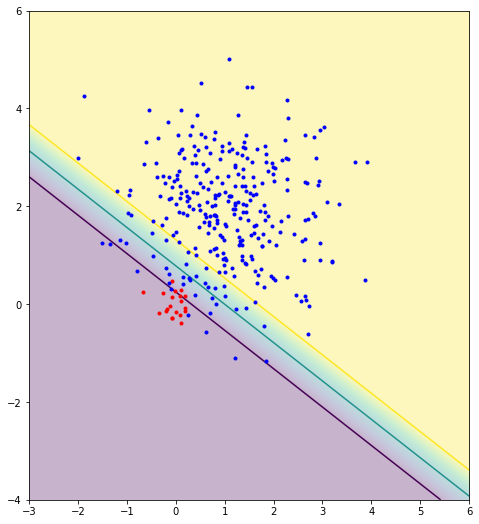

In [59]:
foo(Cneg=1., Cpos=0.1)

If we make the blue class penaly even lower, we will achieve a better classifier for the red class, although many samples of the blue class will fall inside the margin.

Cneg=1.0
Cpos=0.01
optimal


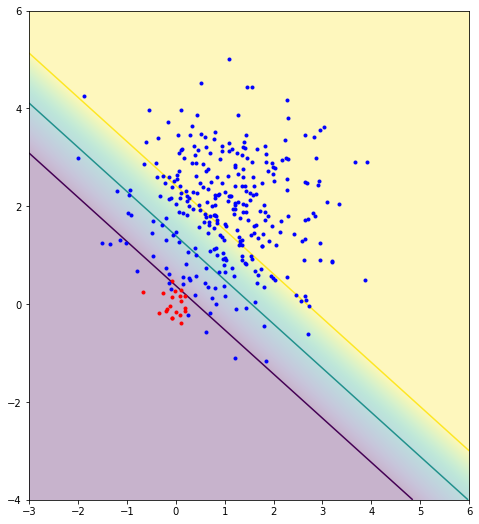

In [60]:
foo(Cneg=1., Cpos=0.01)

## References
* https://stats.stackexchange.com/questions/122095/does-support-vector-machine-handle-imbalanced-dataset
* https://datascienceplus.com/weighted-linear-support-vector-machine/